<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/lupis30puc-update-4/Yelp_evaluation_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [1]:
!pip install transformers

     |████████████████████████████████| 1.8MB 17.2MB/s 
     |████████████████████████████████| 2.9MB 51.9MB/s 
     |████████████████████████████████| 890kB 57.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=5990bd04a9b5ce5b4ffb8e5498e1537eeb3d95a26598cc4e7e5285a0231a1162
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## GPU

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Loading the tensors dataset and model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import pickle

In [9]:
filename = '/content/drive/MyDrive/Yelp/tensors_yelp/test_input_ids_150.pkl'
with open(filename, 'rb') as f:
    test_ids = pickle.load(f)


In [13]:
test_dataset = torch.load('/content/drive/MyDrive/Yelp/tensors_yelp/_test_150')

In [14]:
test_dataset[0]

(tensor([  101,  3752,  2307,  4391,  2245,  4012, 15455,  6072,  3046,  6265,
          4694,  9364, 25545,  2465,  2100,  3737, 23127,  4406,  5171,  4916,
          7884, 11188, 22775,  3491,  3332,  9065, 11772,  4127, 26509,  5359,
         13364, 12183,  5454,  4900,  6265,  2569,  3601,  3760,  4372, 13334,
          2015, 26192,  2094,  7975,  4372,  5428, 27266,  2050, 16709, 12901,
          6581,  2488,  7975,  9610,  7712, 18003,  2050,  5642,  3903,  5785,
         13017, 13435,  4840, 25628,  4825, 21121,  2903,  2155,  2372,  3290,
          2877,  4997,  7615,  7263,  2653,  8803, 20888,  2344,  3737,  6265,
          3325,  4825,  3497,  2709,  6195,  5875, 14927,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# batch size
batch_size = 16

prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
"""
model = BertForSequenceClassification(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
"""
model = torch.load('/content/drive/MyDrive/Yelp/model_save_4/model-24-JAN_150', map_location="cuda:0")  # Choose whatever GPU device number you want
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Evaluating the test set

In [18]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  

#logits = logits[0].detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

    #np.argmax(logits, axis=1).flatten()

In [20]:
total_eval_accuracy = 0
for i in range(len(predictions)):
  total_eval_accuracy += flat_accuracy(predictions[i], true_labels[i])
print(total_eval_accuracy)

37.625


In [21]:
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  Accuracy: 0.92


In [22]:
pred_flat = np.argmax(predictions[0], axis=1).flatten()
labels_flat = true_labels[0].flatten()
tot_ev_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
print(tot_ev_acc)

0.875


## Matthews Corr Coef

In [23]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


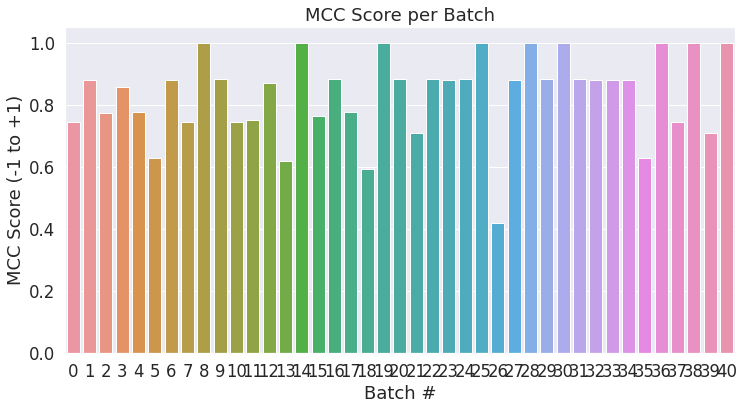

In [24]:
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [25]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.834


# Trying with new sentences/ reviews

In [31]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yelp/model_save_4/')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [33]:
review_example = 'Very friendly and helpful staff. Increasing my Dutch vocabulary during commute thanks to a great suggestion.'

positive_review ='A truly inspiring venue. Friendly, helpful staff. Amazing portraits and awesome surroundings.  Hope to go back sometime soon'
#'Great set up. Very good food. Luxury Bar surroundings. Good food but quite pricey. Staff are polite & very helpful. They all look smart.'


#'Terrible customer service downstairs within the kitchen appliances department.'
negative_review = 'Completely appalled by the lack of assistance or help I received in trying to resolve an issue with an TV that has now been going on for a month. Staff appeared disinterested and unhelpful, despite me explaining I have spent in excess of five hours on hold trying to speak to someone about the resolution of the issue. There is no clarity of who to speak to, no one seems to know what is going on, and no one knows what the resolution is. I appreciate these are challenging times but I and have had no communication in any form from the company, I am the one who appears to doing all the leg work, even having to speak to the repair contractors in person to find out what is happening! Terrible service, terrible aftercare, terrible communication - would seriously advise against making any large electrical purchases from the company.'

## experiments

In [ ]:
example_tokens = tokenizer.encode_plus(review_example, return_token_type_ids=False, return_tensors = 'pt')
example_tokens

{'input_ids': tensor([[  101,  2200,  5379,  1998, 14044,  3095,  1012,  4852,  2026,  3803,
         16188,  2076,  4012, 26746,  4283,  2000,  1037,  2307, 10293,  1012,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
len(example_tokens['input_ids'])

1

In [ ]:
example_tokens['attention_mask']

torch.Tensor

In [ ]:
 # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

In [ ]:
example_attention = example_tokens['attention_mask'].to(device)

In [ ]:
example_ids = example_tokens['input_ids'].to(device)

In [ ]:
 with torch.no_grad():
   #output = model(example_tokens['input_ids'], attention_mask=example_tokens['attention_mask'])[0]
   output = model(example_ids, attention_mask=example_attention)[0]
output = output.detach().cpu().numpy()
pred_flat = np.argmax(output, axis=1).flatten()
print('label')
print(pred_flat.item())

label
1


## the real test
Remember only 2 labels: 0=negative, 1=positive

In [28]:
def encode(sequence):
  """
  The copied version was:
    return tokenizer.encode_plus(
                sequence,
                add_special_tokens=True,
                max_length= 150,
                return_token_type_ids=False,
                padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt',
                truncation = True
    )
  """ 
  return tokenizer.encode_plus(sequence, return_token_type_ids=False, return_tensors = 'pt')

In [29]:
def predict(sequence='I love you a lot. You are really great. You are wonderful and awesome.'):
    encoded = encode(sequence)
    encoded_ids = encoded['input_ids'].to(device)
    enconded_attention = encoded['attention_mask'].to(device)
    with torch.no_grad():
        output = model(encoded_ids, attention_mask=enconded_attention)[0]
        output = output.detach().cpu().numpy()
        pred_flat = np.argmax(output, axis=1).flatten()
        #sig_factor = torch.sigmoid(output) / torch.sigmoid(output).sum()
        #return {'proportional':  sig_factor.numpy().tolist(), 'sigmoid': torch.sigmoid(output).numpy().tolist(), 'stars': pred_flat.item() + 1, 'raw': output.numpy().tolist()}
        return {'label': pred_flat.item()}

In [34]:
predict(positive_review)

{'label': 1}

# Converting input ids back to words:

In [26]:
test_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_650.pkl')
test_df.reset_index(drop=True, inplace=True)
test_df.shape

(650, 3)

In [27]:
test_df.text[2]

'clean hotel jacuzzi huge shower bathroom huge clean view nice hotel lobby nice valet great bad kept freezing hours minutes time floor heard train night thruout night loud clearly freight train engineer thats thing want waking away work makes nights broken sleep night good stay know vegas people hotel sleep'

In [37]:
list(tokenizer.vocab.keys())[4550]

'clean'

In [ ]:
review_test = test_dataset[0][0]

In [35]:
tokenizer.decode(test_dataset[2][0])

'[CLS] clean hotel jacuzzi huge shower bathroom huge clean view nice hotel lobby nice valet great bad kept freezing hours minutes time floor heard train night thruout night loud clearly freight train engineer thats thing want waking away work makes nights broken sleep night good stay know vegas people hotel sleep [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'